<a href="https://colab.research.google.com/github/NisanthanG/Air-Quality-Monitoring-System/blob/main/Air_Quality_Index_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# data preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt
from datetime import datetime
import tensorflow.keras as keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from numpy import polyfit
import urllib.request
%matplotlib inline

In [ ]:
df = pd.read_csv('air_quality_ts.csv',parse_dates={'dt' : ['Date', 'Time']}, sep=" ",infer_datetime_format=True,low_memory=False, na_values=['nan','?'], index_col='dt')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9231 entries, 2022-05-19 00:04:19 to 2022-08-18 23:52:37
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No           9231 non-null   int64  
 1   Profile      9231 non-null   object 
 2   O3           9231 non-null   float64
 3   CO           9231 non-null   float64
 4   NO2          9231 non-null   float64
 5   SO2          9231 non-null   float64
 6   NO           9231 non-null   float64
 7   CO2          9231 non-null   float64
 8   VOC          9231 non-null   float64
 9   PM1          9231 non-null   float64
 10  PM2.5        9231 non-null   float64
 11  PM4          9231 non-null   float64
 12  PM10         9231 non-null   float64
 13  TSP          9231 non-null   float64
 14  TEMP         9231 non-null   float64
 15  HUM          9231 non-null   float64
 16  WS           9231 non-null   float64
 17  WD           9231 non-null   int64  
 18  ISPU        

In [ ]:
df.shape

(9231, 21)

In [ ]:
df.columns

Index(['No', 'Profile', 'O3', 'CO', 'NO2', 'SO2', 'NO', 'CO2', 'VOC', 'PM1',
       'PM2.5', 'PM4', 'PM10', 'TSP', 'TEMP', 'HUM', 'WS', 'WD', 'ISPU',
       'Status', 'Unnamed: 22'],
      dtype='object')

In [ ]:
df_new = df[['PM2.5','PM10','CO','CO2','TEMP','HUM']]

In [ ]:
df_new.tail(5)

,PM2.5,PM10,CO,CO2,TEMP,HUM
dt,,,,,,
2022-08-18 23:12:37,4.5,12.90,0.26,389.93,20.8,68.1
2022-08-18 23:22:37,4.5,5.68,0.20,379.97,20.7,68.0
2022-08-18 23:32:37,4.5,15.43,0.21,385.59,20.6,68.5
2022-08-18 23:42:38,4.5,1.01,0.23,379.31,20.6,68.5
2022-08-18 23:52:37,4.5,15.56,0.23,382.03,20.4,69.1


In [ ]:
# resampling so that the frequency becomes hourly and taking mean
df_new = df_new.resample('H').mean()

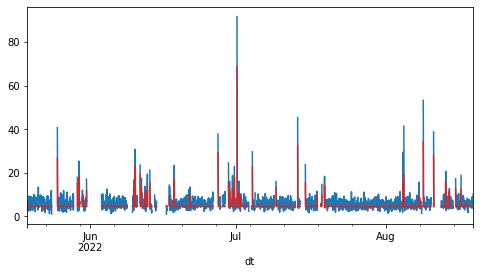

In [ ]:
df_new['PM10'].plot(figsize=(8,4), color="tab:blue");
df_new['PM2.5'].plot(figsize=(8,4), color="tab:red");

In [ ]:
len(df_new)

2208

In [ ]:
df_new_actual = df_new.copy()

In [ ]:
df_new_actual.isnull().sum()

PM2.5    471
PM10     471
CO       471
CO2      471
TEMP     471
HUM      471
dtype: int64

In [ ]:
df_new_actual = df_new_actual.fillna(df_new_actual.mean())

In [ ]:
df_new_actual.shape

(2208, 6)

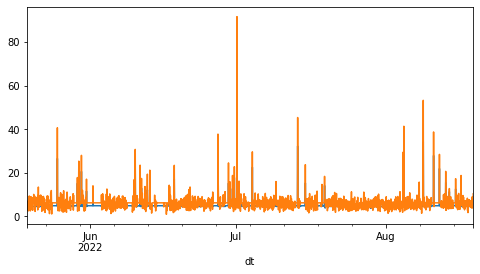

In [ ]:
df_new_actual['PM2.5'].plot(figsize=(8,4));
df_new_actual['PM10'].plot(figsize=(8,4));

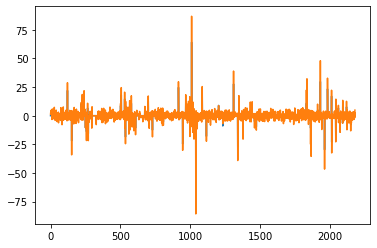

In [ ]:
X = df_new_actual.iloc[:,0:2].values
diff = list()
hours_in_the_period = 30
for i in range(hours_in_the_period, len(X)):
	value = X[i] - X[i - hours_in_the_period]
	diff.append(value)
plt.plot(diff)
plt.show()

               PM2.5      PM10
dt                            
2022-08-14  4.836935  5.944876
2022-08-15  4.943959  6.405781
2022-08-16  4.860729  6.639693
2022-08-17  4.569643  5.253482
2022-08-18  4.500000  5.986472


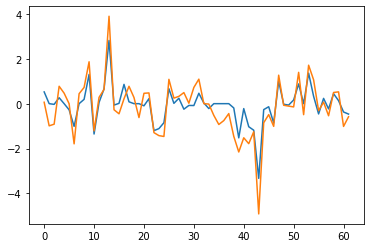

In [ ]:
X = df_new_actual.iloc[:,0:2]
df_daily = X.resample('D')
daily_mean = df_daily.mean()
print(daily_mean.tail())
diff1 = list()
diff2 = list()
days_in_month = 30
for i in range(days_in_month, len(daily_mean)):
  value1 = float(str(daily_mean.iloc[i:i+1,0:1]).split()[-1]) - float(str(daily_mean.iloc[i - days_in_month:i - days_in_month+1,0:1]).split()[-1])
  value2 = float(str(daily_mean.iloc[i:i+1,1:2]).split()[-1]) - float(str(daily_mean.iloc[i - days_in_month:i - days_in_month+1,1:2]).split()[-1])
  diff1.append(value1) 
  diff2.append(value2)
plt.plot(diff1)
plt.plot(diff2)
plt.show()

Coefficients: [[-3.88558922e-03  3.26061484e-03]
 [ 4.87343513e+00  6.12027259e+00]]


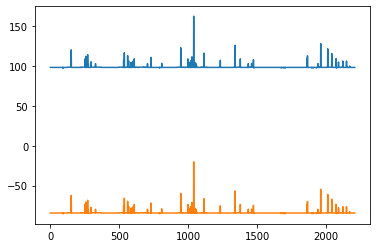

In [ ]:
# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%24 for i in range(0, len(df_new_actual.iloc[:,0:1]))]
y = df_new_actual.iloc[:,0:2].values
degree = 1
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
	value = coef[-1]
	for d in range(degree):
		value += X[i]**(degree-d) * coef[d]
	curve.append(value)
# create seasonally adjusted
value1 = df_new_actual.iloc[:,0:1].values
diff = list()
for i in range(len(value1)):
	value = value1[i] - curve[i]
	diff.append(value)
plt.plot(diff)
plt.show()



In [ ]:
col1, col2 = "PM2.5", "PM10"
corr = df_new_actual[col1].corr(df_new_actual[col2])
print("Correlation between ", col1, " and ", col2, "is: ", round(corr, 2))

col1, col2 = "PM2.5", "PM2.5"
corr = df_new_actual[col1].corr(df_new_actual[col2])
print( "Correlation between ", col1, " and ", col2, "is: ", round(corr, 2))

col1, col2 = "PM10", "PM2.5"
corr = df_new_actual[col1].corr(df_new_actual[col2])
print( "Correlation between ", col1, " and ", col2, "is: ", round(corr, 2))

col1, col2 = "PM10", "PM10"
corr = df_new_actual[col1].corr(df_new_actual[col2])
print( "Correlation between ", col1, " and ", col2, "is: ", round(corr, 2))


Correlation between  PM2.5  and  PM10 is:  0.88
Correlation between  PM2.5  and  PM2.5 is:  1.0
Correlation between  PM10  and  PM2.5 is:  0.88
Correlation between  PM10  and  PM10 is:  1.0


In [ ]:
# Select features (columns) to be involved intro training and predictions
cols = list(df_new.iloc[0:1,0:2])

# Extract dates (will be used in visualization)
datelist_train = list(df_new_actual.index)
datelist_train = [date for date in datelist_train]

print('Training set shape == {}'.format(df_new_actual.iloc[:,0:2].shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (2208, 2)
All timestamps == 2208
Featured selected: ['PM2.5', 'PM10']


In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
training_set = df_new_actual[cols]
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set.iloc[:,0:1])

array([[-0.14496014],
       [-0.14496014],
       [-0.14496014],
       ...,
       [-0.14496014],
       [-0.14496014],
       [-0.14496014]])

             PM2.5         PM10
count  2208.000000  2208.000000
mean      4.828751     6.157770
std       2.268384     3.680193
min       3.375000     0.885000
25%       4.500000     4.697500
50%       4.500000     6.157770
75%       4.500000     6.557500
max      68.700000    91.600000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fafb680a3d0>,
      dtype=object)

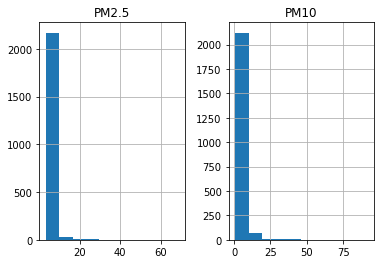

In [ ]:
print(training_set.describe())
training_set.hist()

In [ ]:
%load_ext tensorboard

In [ ]:
log_folder= 'logs'
%reload_ext tensorboard

In [ ]:
df_new_actual.mean()

PM2.5      0.383692
PM10       6.157770
CO         0.233172
CO2      394.616480
TEMP      25.266942
HUM       77.634191
dtype: float64

In [ ]:
# Creating a data structure with 21 days timestamps and 1 output
X_train = []
y_train = []

n_future = 7   # Number of days we want top predict into the future
n_past = 96    # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df_new.shape[0]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (2106, 96, 2).
y_train shape == (2106, 1).


In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=2,
                      padding="causal",strides=1,
                      activation='relu',
                      input_shape=[None, 2]),
  tf.keras.layers.Conv1D(filters=32, kernel_size=2,
                      padding="causal",strides=1,
                      activation='relu',
                      input_shape=[None, 2]),
  tf.keras.layers.MaxPool1D(),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.LSTM(64,return_sequences=True),
])
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Lambda(lambda x: x * 200))

optimizer = keras.optimizers.SGD(learning_rate=1.5*1e-5,momentum=0.95)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mse','accuracy'])
from keras import backend as K
#def root_mean_squared_error(y_true, y_pred):
#        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
#model.compile(optimizer = "rmsprop", loss = root_mean_squared_error, metrics =["accuracy"])


In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_37 (Conv1D)          (None, None, 32)          160       
                                                                 
 conv1d_38 (Conv1D)          (None, None, 32)          2080      
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, None, 32)         0         
 g1D)                                                            
                                                                 
 bidirectional_32 (Bidirecti  (None, None, 64)         16640     
 onal)                                                           
                                                                 
 lstm_48 (LSTM)              (None, None, 64)          33024     
                                                                 
 bidirectional_33 (Bidirecti  (None, 64)             

In [ ]:
callbacks = [TensorBoard(log_dir=log_folder, histogram_freq=1, 
 write_graph=True, write_images=True,     
 update_freq='epoch', profile_batch=2)]

In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks = callbacks)

Epoch 1/100
53/53 [==============================] - 20s 171ms/step - loss: 0.1440 - mse: 1.0831 - accuracy: 0.2280 - val_loss: 0.1968 - val_mse: 1.2550 - val_accuracy: 0.1540
Epoch 2/100
53/53 [==============================] - 6s 108ms/step - loss: 0.1392 - mse: 1.0749 - accuracy: 0.2286 - val_loss: 0.1778 - val_mse: 1.2306 - val_accuracy: 0.1540
Epoch 3/100
53/53 [==============================] - 6s 110ms/step - loss: 0.1266 - mse: 1.0550 - accuracy: 0.2381 - val_loss: 0.1583 - val_mse: 1.2520 - val_accuracy: 0.1588
Epoch 4/100
53/53 [==============================] - 6s 105ms/step - loss: 0.1178 - mse: 1.0358 - accuracy: 0.2399 - val_loss: 0.1549 - val_mse: 1.2259 - val_accuracy: 0.1588
Epoch 5/100
53/53 [==============================] - 5s 103ms/step - loss: 0.1177 - mse: 1.0381 - accuracy: 0.2393 - val_loss: 0.1616 - val_mse: 1.2745 - val_accuracy: 0.1588
Epoch 6/100
53/53 [==============================] - 6s 107ms/step - loss: 0.1155 - mse: 1.0242 - accuracy: 0.2399 - val_los

In [ ]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [ ]:
datelist_train[-1]

Timestamp('2022-08-18 23:00:00', freq='H')

In [ ]:
datelist_future_

[datetime.date(2022, 8, 18),
 datetime.date(2022, 8, 19),
 datetime.date(2022, 8, 20),
 datetime.date(2022, 8, 21),
 datetime.date(2022, 8, 22),
 datetime.date(2022, 8, 23),
 datetime.date(2022, 8, 24)]

In [ ]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])
predictions_train = model.predict(X_train[n_past:])

In [ ]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['PM2.5']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['PM2.5']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

In [ ]:
PREDICTIONS_FUTURE

,PM2.5
2022-08-18 23:00:00,0.556204
2022-08-19 23:00:00,0.565013
2022-08-20 23:00:00,0.567837
2022-08-21 23:00:00,0.575656
2022-08-22 23:00:00,0.570114
2022-08-23 23:00:00,0.572166
2022-08-24 23:00:00,0.571216


In [ ]:
PREDICTION_TRAIN

,PM2.5
2022-05-27 06:00:00,0.558531
2022-05-27 07:00:00,0.558525
2022-05-27 08:00:00,0.576791
2022-05-27 09:00:00,0.567827
2022-05-27 10:00:00,0.579080
...,...
2022-08-18 19:00:00,0.567837
2022-08-18 20:00:00,0.575656
2022-08-18 21:00:00,0.570114
2022-08-18 22:00:00,0.572166


Text(0, 0.5, 'PM 2.5')

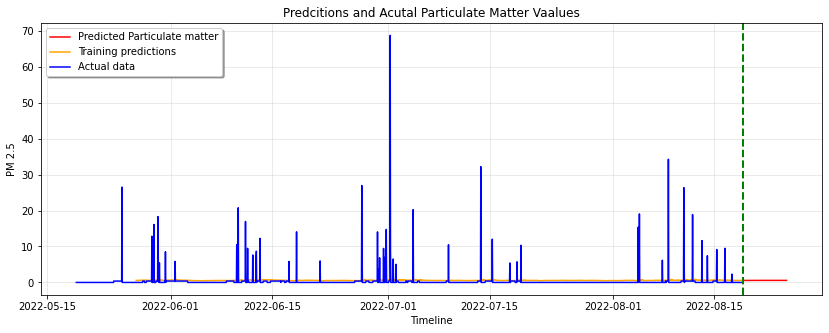

In [ ]:
# Set plot size 
# from pylab import rcParams
plt.rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2019-07-27'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['PM2.5'], color='r', label='Predicted Particulate matter')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['PM2.5'], color='orange', label='Training predictions')
plt.plot(df_new_actual.loc[START_DATE_FOR_PLOTTING:].index, df_new_actual.loc[START_DATE_FOR_PLOTTING:]['PM2.5'], color='b', label='Actual data')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Particulate Matter Vaalues', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('PM 2.5', family='Arial', fontsize=10)
# plt.xticks(rotation=45, fontsize=8)
# plt.show()

(1.0, 100.0, 0.0, 1.0)

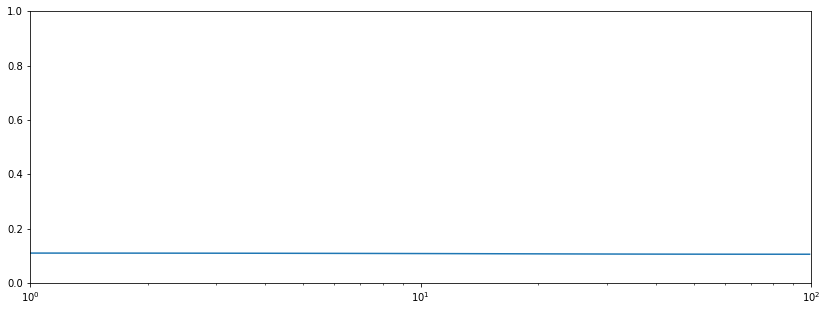

In [ ]:
import matplotlib.pyplot as plt

plt.semilogx(history.history["loss"])
plt.axis([1, 100, 0, 1])


(1.0, 100.0, 0.0, 1.0)

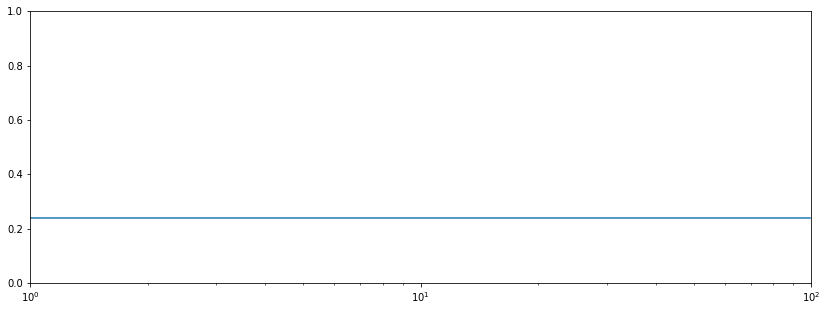

In [ ]:

plt.semilogx(history.history["accuracy"])
plt.axis([1, 100, 0, 1])

(1.0, 100.0, 0.0, 2.0)

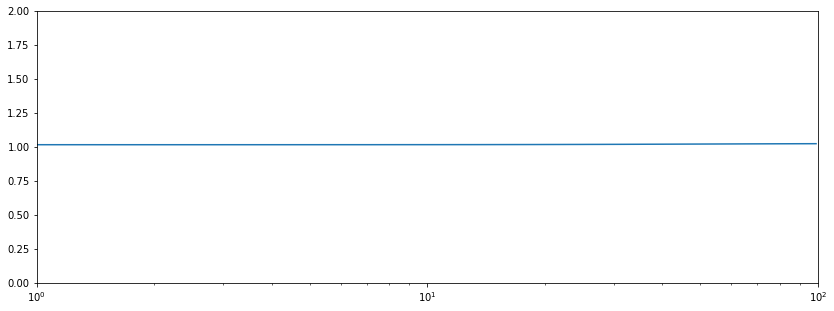

In [ ]:
plt.semilogx(history.history["mse"])
plt.axis([1, 100, 0, 2])

In [ ]:
from time import sleep
for i in range(PREDICTIONS_FUTURE.shape[0]):
  value = str(PREDICTIONS_FUTURE.iloc[i:i+1,0:1])
  valuelist=value.split()
  val = valuelist[-1]
  print(val)
  val = val.replace(' ', "%20")
  val = val.replace('\n', "%0A")
  b=urllib.request.urlopen('https://api.thingspeak.com/update?api_key=LZAJPLQ3O40YZ6FT&field1='+ val)
  sleep(15)

-0.312888
-0.238892
-0.178366


In [ ]:
%tensorboard --logdir logs